[152, 102]


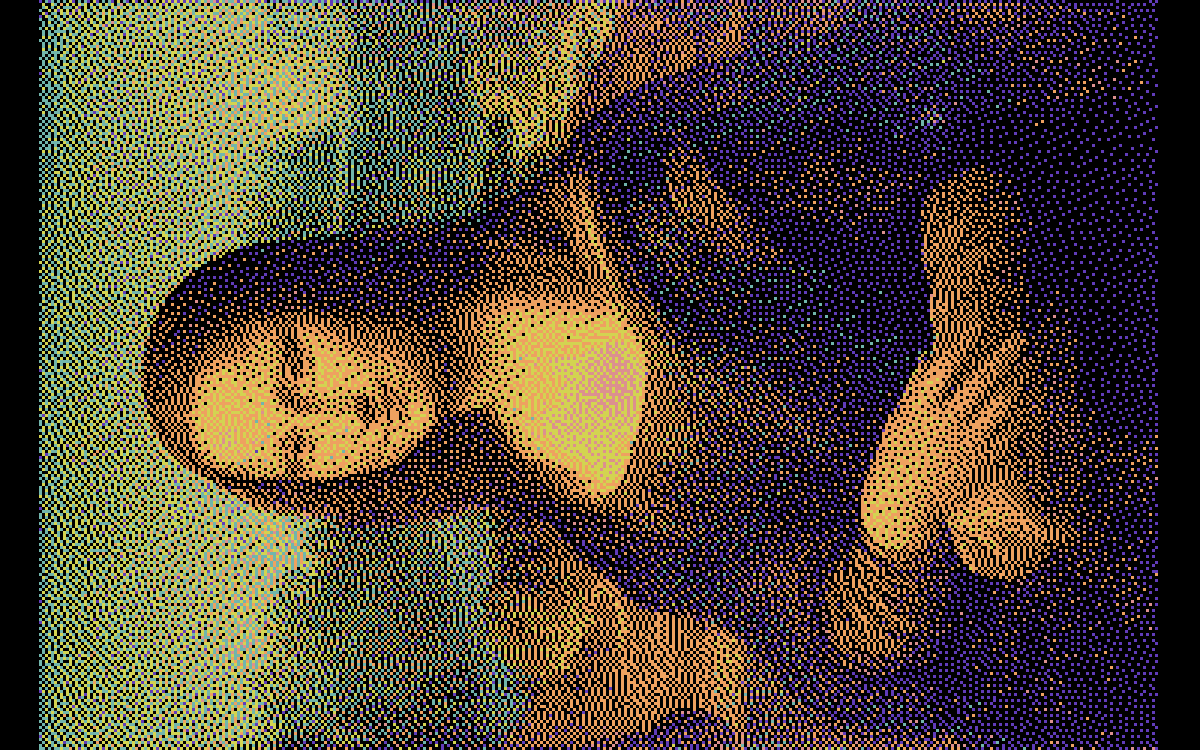

In [1]:
from PIL import Image
from PIL import ImagePalette
from PIL import ImageOps
import numpy as np
import pandas as pd
import requests
import json
from requests.structures import CaseInsensitiveDict

f_size=(400,250)

#low the image with mpimg.read
img = Image.open("images/mona.jpg")
original_shape=[int(img.size[0]/10), int(img.size[1]/10)]
print(original_shape)

img.thumbnail(f_size)
img = ImageOps.pad(img,size=f_size, color=(0,0,0))



# Send a GET method to http://www.bioartbot.org/artpieces and get the response
response = requests.get('http://www.bioartbot.org/artpieces')
# parse the response into a json
data = json.loads(response.text)

pall = []

for i in data["meta"]["bacterial_colors"]:
    pall = pall + [i["rgba"][:-1]]

#fill pall with (0,0,0) until have 256 as the length
pall = pall + [(0,0,0)] * (256 - len(pall))

#flatten pall
pall = [item for sublist in pall for item in sublist]

#create a new palette
p_img = Image.new('P', (1, 1))
p_img.putpalette(pall)

img2 = img.quantize("P", palette=p_img, dither=1)

display(img2.resize((f_size[0]*3, f_size[1]*3)))





In [2]:
color_dict = {}
for i in range(0,img2.size[0]):
    for j in range(0,img2.size[1]):
        color = str(img2.getpixel((i,j)) + 1)
        if color != "6":
            #append color to color_dict[color]
            if color in color_dict:
                color_dict[color].append((j,i))
            else:
                color_dict[color] = [(j,i)]
                



In [3]:
data = {
    "email":"franxi2953@gmail.com",
    "title": "mona lisa",
    "art": color_dict,
    "canvas_size":{"x":f_size[0],"y":f_size[1]},
}

data_json = json.dumps(data)

headers = CaseInsensitiveDict()
headers["Content-Type"] = "application/json"
headers["dataType"] = "json"

#send a post request to http://www.bioartbot.org/artpieces
#response = requests.post('http://www.bioartbot.org/artpieces', data=data_json, headers=headers)
display(response.text)

'{"data":null,"meta":{"bacterial_colors":[{"id":1,"name":"pink","rgba":[220,144,143,1]},{"id":2,"name":"blue","rgba":[97,60,186,1]},{"id":3,"name":"teal","rgba":[113,181,172,1]},{"id":4,"name":"peach","rgba":[238,161,96,1]},{"id":5,"name":"fluorescent yellow","rgba":[211,211,81,1]}],"submission_limit_exceeded":false}}\n'

In [211]:
# pretiffy data_json
data_json = json.dumps(data, indent=4, sort_keys=True)

# save it to a file
with open("mona.json", "w") as f:
    f.write(data_json)
    

In [16]:
# OPTIMIZATION ALGORITHM PIXELS TOO CLOSE STYLE
def module_to_last(p1,p2):
    module = np.sqrt((p1["x"] - p2[0])**2 + (p1["y"] - p2[1])**2)
    return module

def register_pixels_too_close(pixels_too_close, new_pixels):
    #reduce all existing time-to-live counters by 1
    pixels_too_close.ttl = pixels_too_close.ttl - 1

    #format new pixels and add them to existing list
    new_pixels_with_ttl = pd.DataFrame(columns = ["pixel_index", "ttl"])
    new_pixels_with_ttl["pixel_index"] = new_pixels.index
    new_pixels_with_ttl["ttl"] = 10

    final_pixels = pd.concat([pixels_too_close, new_pixels_with_ttl], axis=0)

    #if a pixel was already in the list, drop the old one so that we use the new one with ttl=10
    final_pixels = final_pixels.drop_duplicates(subset=["pixel_index"], keep='last')

    #Drop anything where the time-to-live = 0
    final_pixels = final_pixels.loc[final_pixels.ttl > 0]

    return final_pixels

def optimize_print_order(unoptimize_list,units_per_mm,minimun_module_mm=2):

    minimun_module_unit = minimun_module_mm * units_per_mm
    # add the first pixel to optimized_list
    optimized_list = [unoptimize_list[0]]

    #calculate the module for the rest of pixels
    # dataframe from columns x and y
    df = pd.DataFrame(unoptimize_list[1:], columns=["x","y"])

    pixels_too_close = pd.DataFrame(columns=["pixel_index", "ttl"])

    while len(df) > 0:
        df["module"] = df.apply(module_to_last, args=(optimized_list[-1:]),axis=1)
        pixels_too_close = register_pixels_too_close(pixels_too_close, df[df["module"] <= minimun_module_unit])
        pixels_far_enough = df.loc[~df.index.isin(pixels_too_close.pixel_index)]
        # If there are pixels far enough, add the nearer one to optimized_list
        if len(pixels_far_enough) > 0:
            # add the nearest pixel to optimized_list
            next_pixel = pixels_far_enough.loc[pixels_far_enough["module"].idxmin()][["x","y"]]
        else:
            # if there are no pixels far enough, add the fardest pixel to optimized_list
            next_pixel = df.loc[df["module"].idxmax()][["x","y"]]

        optimized_list = optimized_list + [next_pixel.tolist()]
        # remove it from the df
        df = df[df.index != next_pixel.name]

    return optimized_list
